# Data Science Project: Analyze COVID-19 vaccination data

Data Source: https://www.kaggle.com/ayushggarg/covid19-vaccine-adverse-reactions?select=2021VAERSSYMPTOMS.csv
Data Guide: https://vaers.hhs.gov/docs/VAERSDataUseGuide_November2020.pdf

https://www.kaggle.com/nvkex0/covid-19-vaccine-s-adverse-reactions

* VAERS: Vaccine Adverse Event Reporting System
* dataset created by the Food andd Drug Administration and Centers for Disease Control and Prevention to
receive reports about adverse events that may be associated with vaccines
* data contains only patients with symptoms, so we don't know the overall number of vaccinated people 
* 2 forms (VAERS 1, VAERS 2) existing with slightly different fields (description in guide)
* data is from 2021, latest date: 01/29/2021

## Business Understanding - Questions:
* What are the most common side effects?
* Do certain allergies or birth defects lead to side effects or death?
* What role does age play for side effects?
* Is there an interaction between the vaccine and specific side effects?
* prediction question?

## Data Understanding

* data sets: patients data (df_patients), data about their symptoms (df_symptoms) , data about the vaccines (df_vax)
* we can identify the patients with "VAERS_ID" for all data sets $\rightarrow$ 2946 patients

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

%matplotlib inline

In [2]:
# read in all datasets
df_patients = pd.read_csv('./data/2021VAERSDATA.csv', engine='python')
df_symptoms = pd.read_csv('./data/2021VAERSSYMPTOMS.csv')
df_vax = pd.read_csv('./data/2021VAERSVAX.csv')

In [3]:
print(df_patients.shape)
print(df_symptoms.shape)
print(df_vax.shape)

(2946, 35)
(4712, 11)
(3014, 8)


In [4]:
print(df_patients.columns)

Index(['VAERS_ID', 'RECVDATE', 'STATE', 'AGE_YRS', 'CAGE_YR', 'CAGE_MO', 'SEX',
       'RPT_DATE', 'SYMPTOM_TEXT', 'DIED', 'DATEDIED', 'L_THREAT', 'ER_VISIT',
       'HOSPITAL', 'HOSPDAYS', 'X_STAY', 'DISABLE', 'RECOVD', 'VAX_DATE',
       'ONSET_DATE', 'NUMDAYS', 'LAB_DATA', 'V_ADMINBY', 'V_FUNDBY',
       'OTHER_MEDS', 'CUR_ILL', 'HISTORY', 'PRIOR_VAX', 'SPLTTYPE',
       'FORM_VERS', 'TODAYS_DATE', 'BIRTH_DEFECT', 'OFC_VISIT', 'ER_ED_VISIT',
       'ALLERGIES'],
      dtype='object')


In [5]:
print(df_symptoms.columns)

Index(['VAERS_ID', 'SYMPTOM1', 'SYMPTOMVERSION1', 'SYMPTOM2',
       'SYMPTOMVERSION2', 'SYMPTOM3', 'SYMPTOMVERSION3', 'SYMPTOM4',
       'SYMPTOMVERSION4', 'SYMPTOM5', 'SYMPTOMVERSION5'],
      dtype='object')


In [6]:
print(df_vax.columns)

Index(['VAERS_ID', 'VAX_TYPE', 'VAX_MANU', 'VAX_LOT', 'VAX_DOSE_SERIES',
       'VAX_ROUTE', 'VAX_SITE', 'VAX_NAME'],
      dtype='object')


In [7]:
# check if all datasets have the same number of patients
print(df_patients["VAERS_ID"].nunique())
print(df_symptoms["VAERS_ID"].nunique())
print(df_vax["VAERS_ID"].nunique())

2946
2946
2946


In [8]:
df_patients.head()

,VAERS_ID,RECVDATE,STATE,AGE_YRS,CAGE_YR,CAGE_MO,SEX,RPT_DATE,SYMPTOM_TEXT,DIED,...,CUR_ILL,HISTORY,PRIOR_VAX,SPLTTYPE,FORM_VERS,TODAYS_DATE,BIRTH_DEFECT,OFC_VISIT,ER_ED_VISIT,ALLERGIES
0,916710,01/01/2021,MO,23.0,23.0,NaN,F,NaN,"Acute appendicitis, onset morning of 1/1/2021 ...",NaN,...,NaN,Hypothyroidism,NaN,NaN,2,01/01/2021,NaN,NaN,Y,NKDA
1,916741,01/01/2021,AR,68.0,68.0,NaN,F,NaN,"on dec 22 I felt some myalgias, chills, fatigu...",NaN,...,had surgery R hand for advanced arthritis 11/1...,Rheumatoid arthritis - mostly affecting R wris...,NaN,NaN,2,01/01/2021,NaN,NaN,NaN,bee stings
2,916742,01/01/2021,MN,29.0,29.0,NaN,F,NaN,Within 15 minutes of receiving the vaccine I b...,NaN,...,None,Sports induced asthma,NaN,NaN,2,01/01/2021,NaN,Y,Y,"Amoxicillin, penicillin, oxycodone, roxicodone..."
3,916746,01/01/2021,TX,49.0,49.0,NaN,F,NaN,Anaphylaxis. Immediately experienced shortness...,NaN,...,None,None,NaN,NaN,2,01/01/2021,NaN,NaN,Y,"Shellfish, Iodine"
4,916772,01/01/2021,GA,55.0,55.0,NaN,M,NaN,Vaccine on 12/22/2020 and started feeling bad ...,NaN,...,NaN,"HTN, Insomnia,High Cholesterol,",NaN,NaN,2,01/01/2021,NaN,Y,NaN,Codeine


In [9]:
# Look at datatypes
df_patients.dtypes

VAERS_ID          int64
RECVDATE         object
STATE            object
AGE_YRS         float64
CAGE_YR         float64
CAGE_MO         float64
SEX              object
RPT_DATE         object
SYMPTOM_TEXT     object
DIED             object
DATEDIED         object
L_THREAT         object
ER_VISIT        float64
HOSPITAL         object
HOSPDAYS        float64
X_STAY           object
DISABLE          object
RECOVD           object
VAX_DATE         object
ONSET_DATE       object
NUMDAYS         float64
LAB_DATA         object
V_ADMINBY        object
V_FUNDBY         object
OTHER_MEDS       object
CUR_ILL          object
HISTORY          object
PRIOR_VAX        object
SPLTTYPE         object
FORM_VERS         int64
TODAYS_DATE      object
BIRTH_DEFECT     object
OFC_VISIT        object
ER_ED_VISIT      object
ALLERGIES        object
dtype: object

In [10]:
df_symptoms.head()

,VAERS_ID,SYMPTOM1,SYMPTOMVERSION1,SYMPTOM2,SYMPTOMVERSION2,SYMPTOM3,SYMPTOMVERSION3,SYMPTOM4,SYMPTOMVERSION4,SYMPTOM5,SYMPTOMVERSION5
0,916710,Appendicitis,23.1,Band neutrophil percentage increased,23.1,Surgery,23.1,White blood cell count increased,23.1,NaN,NaN
1,916741,Chills,23.1,Complex regional pain syndrome,23.1,Fatigue,23.1,Headache,23.1,Joint range of motion decreased,23.1
2,916741,Myalgia,23.1,Pain in extremity,23.1,Peripheral swelling,23.1,X-ray abnormal,23.1,NaN,NaN
3,916742,Anaphylactic reaction,23.1,Blood test,23.1,Burning sensation,23.1,Central venous catheterisation,23.1,Dysphonia,23.1
4,916742,Intensive care,23.1,Pruritus,23.1,Rash,23.1,Rash macular,23.1,Throat tightness,23.1


In [11]:
df_vax.head()

,VAERS_ID,VAX_TYPE,VAX_MANU,VAX_LOT,VAX_DOSE_SERIES,VAX_ROUTE,VAX_SITE,VAX_NAME
0,916710,COVID19,MODERNA,NaN,1,IM,LA,COVID19 (COVID19 (MODERNA))
1,916741,COVID19,PFIZER\BIONTECH,EH9899,1,SYR,LA,COVID19 (COVID19 (PFIZER-BIONTECH))
2,916742,COVID19,PFIZER\BIONTECH,NaN,1,IM,NaN,COVID19 (COVID19 (PFIZER-BIONTECH))
3,916746,COVID19,MODERNA,037K20A,1,IM,LA,COVID19 (COVID19 (MODERNA))
4,916772,COVID19,PFIZER\BIONTECH,EJ1685,UNK,IM,LA,COVID19 (COVID19 (PFIZER-BIONTECH))


## Data Preparation / Cleaning

### General Data Cleaning

In [12]:
def cols_all_nan(df):
    ''' Returns columns with NaN for every row in df
    
    INPUT:
    df - pandas dataframe
    
    OUTPUT:
    list of column indices for all columns with all NaN values 
    '''
    return df.columns[df.isnull().all()]

In [13]:
def cols_with_nan(df, percentage):
    '''Returns the column names that have more than (percentage * 100) %
    of their values missing
    
    INPUT:
    df - pandas dataframe
    percentage - float, percentage of values missing

    OUTPUT:
    list of column indices for all columns where more than (percentage * 100) %
    of their values are missing
    '''
    return df.columns[np.sum(df.isnull())/df.shape[0] > percentage]

In [14]:
print("Cols NaN for all rows: ", cols_all_nan(df_patients)) 
print("Cols NaN for all rows: ", cols_all_nan(df_symptoms))
print("Cols NaN for all rows: ", cols_all_nan(df_vax))

Cols NaN for all rows:  Index(['ER_VISIT'], dtype='object')
Cols NaN for all rows:  Index([], dtype='object')
Cols NaN for all rows:  Index([], dtype='object')


In [15]:
print(cols_with_nan(df_patients, 0.5))
print(cols_with_nan(df_symptoms, 0.5))
print(cols_with_nan(df_vax, 0.5))

Index(['CAGE_MO', 'RPT_DATE', 'DIED', 'DATEDIED', 'L_THREAT', 'ER_VISIT',
       'HOSPITAL', 'HOSPDAYS', 'X_STAY', 'DISABLE', 'V_FUNDBY', 'CUR_ILL',
       'PRIOR_VAX', 'SPLTTYPE', 'BIRTH_DEFECT', 'OFC_VISIT', 'ER_ED_VISIT',
       'ALLERGIES'],
      dtype='object')
Index(['SYMPTOM5', 'SYMPTOMVERSION5'], dtype='object')
Index([], dtype='object')


#### Drop columns with NaNs / irrelevant information

In [16]:
# column "ER_VISIT" is NaN for all entries, for form 2 replaced by "ER_ED_VISIT" -> can be dropped (only 7 entries with form 1)
df_patients.drop(columns="ER_VISIT", inplace=True)

# cage_mo: calculated age of patient in months -> only available for babies <= 2.0 years (= 8 patients, 0.2% of data) 
# -> decision: age in years is enough for now 
df_patients.drop(columns="CAGE_MO", inplace=True)

# column "RPT_Date" only available for 7 patients (= date form was completed), discontinued for form 2 -> can be dropped
df_patients.drop(columns="RPT_DATE", inplace=True)

# column "V_FUNDBY" is VAERS1 only field, (= funds used to purchase the vaccines) -> not relevant to us, can be dropped
df_patients.drop(columns="V_FUNDBY", inplace=True)

#### Binary columns

In [17]:
# for all columns in y_col, the values are either "Y" or NaN otherwise -> replace by 1 and 0
y_cols = ["ER_ED_VISIT", "DIED", "L_THREAT", "HOSPITAL", "X_STAY", "DISABLE", "BIRTH_DEFECT", "OFC_VISIT"]

for col in y_cols:
    df_patients[col] = np.where(df_patients[col] == "Y", 1, 0)

In [18]:
print("Remaining cols with NaNs are the following: ")
print(cols_with_nan(df_patients, 0.5).values)
print("They are filled with text descriptions or dates, so there is no easy way to replace NaNs but they could be relevant, so for now I will try to work around.")

Remaining cols with NaNs are the following: 
['DATEDIED' 'HOSPDAYS' 'CUR_ILL' 'PRIOR_VAX' 'SPLTTYPE' 'ALLERGIES']
They are filled with text descriptions or dates, so there is no easy way to replace NaNs but they could be relevant, so for now I will try to work around.


#### Replace values that actually mean "NaN" (differs slightly for the respective columns) 

In [19]:
# for the column "CUR_ILL", some of the entries are "None" or "No" (as string) -> change to NaN
df_patients["CUR_ILL"].replace(
    ["None", "No", "NONE", "unknown", "Unknown", "none", "no", "None known", "none known", 
     "None reported", "none reported", "UNKNOWN", "N/a", "None stated/Denied",
    "No other illness prior to vaccination or within the month prior", "NKDA"], 
    np.nan, inplace=True)

In [20]:
# for the column "ALLERGIES", some of the entries are "None" or "No" (as string) -> change to NaN
df_patients["ALLERGIES"].replace(
    ["None", "none", "NKDA", "NKA", "No known allergies", "unknown", 
     "No", "Unknown", "no", "NONE", "No Known Allergies", "no known allergies",
    "nka", "None known", "NKA to medications", "No known allergies to drugs or food"], np.nan, inplace=True)

In [21]:
# for the column "HISTORY", some of the entries are "None" or "No" (as string) -> change to NaN
df_patients["HISTORY"].replace(["None", "none", "unknown", "unsure", "Unknown", "no", 
                                "Unsure", "No", "NONE", "UNKNOWN", "N/a", "None known",
                               "None reported", "none reported", "None stated/Denied", 
                                "none known"
                               ], np.nan, inplace=True)

In [22]:
# Replacing NaN value with 0 makes sense for counting of days being hospitalized
df_patients["HOSPDAYS"].replace(np.nan, 0, inplace=True)

#### Explanation for Symptoms Text in Patients Dataset
Reported Symptom Text (SYMPTOM_TEXT): This is the symptom text
recorded in the form (in df_patients). MedDRA Terms are derived from this text and placed in the
VAERSSYMPTOMS file.
$\rightarrow$ "SYMPTOM_TEXT" can be ignored, order of terms in df_symptoms are not relevant

In [23]:
# Transform the symptoms dataset so that there is only one column for the symptoms
df_symptoms_m = pd.melt(df_symptoms, id_vars=['VAERS_ID'], value_vars=['SYMPTOM1', 'SYMPTOM2', 
                                                                'SYMPTOM3', 'SYMPTOM4', 'SYMPTOM5'],
                     var_name='NUMBER', value_name='SYMPTOM')
df_symptoms_m.dropna(subset=['SYMPTOM'], inplace=True)

df_symptoms_m.head()

,VAERS_ID,NUMBER,SYMPTOM
0,916710,SYMPTOM1,Appendicitis
1,916741,SYMPTOM1,Chills
2,916741,SYMPTOM1,Myalgia
3,916742,SYMPTOM1,Anaphylactic reaction
4,916742,SYMPTOM1,Intensive care


In [24]:
print(df_patients.shape)
print(df_symptoms_m.shape)
print(df_vax.shape)

(2946, 31)
(16243, 3)
(3014, 8)


**Observation:**  
While for the patients dataset there is only one entry per person (2964 patients in total), it can be more than one entry (row) for the other datasets (> 1 symptom for one patient, > 1 vaccination per person).  
I'm only interested in the COVID19 vaccinations, so I will drop the others. Since there are only 120 other vaccination entries, a comparison wouldn't work well anyway.

In [25]:
covid_ids = df_vax[df_vax["VAX_TYPE"] == "COVID19"]["VAERS_ID"].unique().tolist()
print("# Patients with covid vaccination: ", len(covid_ids))
covid_patients = df_patients[df_patients["VAERS_ID"].isin(covid_ids)]
print("# Patients of reduced patients dataset: ", covid_patients["VAERS_ID"].shape)
covid_symptoms = df_symptoms_m[df_symptoms_m["VAERS_ID"].isin(covid_ids)]
print("# Patients of reduced symptoms dataset: ", covid_symptoms["VAERS_ID"].shape)
covid_vax = df_vax[df_vax["VAERS_ID"].isin(covid_ids)]
print("# Patients of reduced vax dataset: ", covid_vax["VAERS_ID"].shape)

# Patients with covid vaccination:  2820
# Patients of reduced patients dataset:  (2820,)
# Patients of reduced symptoms dataset:  (15597,)
# Patients of reduced vax dataset:  (2853,)


In [26]:
# patient_vax = covid_patients.merge(covid_vax, on="VAERS_ID")
# patient_vax.head()

In [27]:
patient_symp = covid_patients.merge(covid_symptoms, on="VAERS_ID")
patient_symp.head()

,VAERS_ID,RECVDATE,STATE,AGE_YRS,CAGE_YR,SEX,SYMPTOM_TEXT,DIED,DATEDIED,L_THREAT,...,PRIOR_VAX,SPLTTYPE,FORM_VERS,TODAYS_DATE,BIRTH_DEFECT,OFC_VISIT,ER_ED_VISIT,ALLERGIES,NUMBER,SYMPTOM
0,916710,01/01/2021,MO,23.0,23.0,F,"Acute appendicitis, onset morning of 1/1/2021 ...",0,NaN,1,...,NaN,NaN,2,01/01/2021,0,0,1,NaN,SYMPTOM1,Appendicitis
1,916710,01/01/2021,MO,23.0,23.0,F,"Acute appendicitis, onset morning of 1/1/2021 ...",0,NaN,1,...,NaN,NaN,2,01/01/2021,0,0,1,NaN,SYMPTOM2,Band neutrophil percentage increased
2,916710,01/01/2021,MO,23.0,23.0,F,"Acute appendicitis, onset morning of 1/1/2021 ...",0,NaN,1,...,NaN,NaN,2,01/01/2021,0,0,1,NaN,SYMPTOM3,Surgery
3,916710,01/01/2021,MO,23.0,23.0,F,"Acute appendicitis, onset morning of 1/1/2021 ...",0,NaN,1,...,NaN,NaN,2,01/01/2021,0,0,1,NaN,SYMPTOM4,White blood cell count increased
4,916741,01/01/2021,AR,68.0,68.0,F,"on dec 22 I felt some myalgias, chills, fatigu...",0,NaN,0,...,NaN,NaN,2,01/01/2021,0,0,0,bee stings,SYMPTOM1,Chills


In [28]:
pt_symp_vax = patient_symp.merge(covid_vax[["VAERS_ID", "VAX_MANU"]], on="VAERS_ID")
pt_symp_vax.head()

,VAERS_ID,RECVDATE,STATE,AGE_YRS,CAGE_YR,SEX,SYMPTOM_TEXT,DIED,DATEDIED,L_THREAT,...,SPLTTYPE,FORM_VERS,TODAYS_DATE,BIRTH_DEFECT,OFC_VISIT,ER_ED_VISIT,ALLERGIES,NUMBER,SYMPTOM,VAX_MANU
0,916710,01/01/2021,MO,23.0,23.0,F,"Acute appendicitis, onset morning of 1/1/2021 ...",0,NaN,1,...,NaN,2,01/01/2021,0,0,1,NaN,SYMPTOM1,Appendicitis,MODERNA
1,916710,01/01/2021,MO,23.0,23.0,F,"Acute appendicitis, onset morning of 1/1/2021 ...",0,NaN,1,...,NaN,2,01/01/2021,0,0,1,NaN,SYMPTOM2,Band neutrophil percentage increased,MODERNA
2,916710,01/01/2021,MO,23.0,23.0,F,"Acute appendicitis, onset morning of 1/1/2021 ...",0,NaN,1,...,NaN,2,01/01/2021,0,0,1,NaN,SYMPTOM3,Surgery,MODERNA
3,916710,01/01/2021,MO,23.0,23.0,F,"Acute appendicitis, onset morning of 1/1/2021 ...",0,NaN,1,...,NaN,2,01/01/2021,0,0,1,NaN,SYMPTOM4,White blood cell count increased,MODERNA
4,916741,01/01/2021,AR,68.0,68.0,F,"on dec 22 I felt some myalgias, chills, fatigu...",0,NaN,0,...,NaN,2,01/01/2021,0,0,0,bee stings,SYMPTOM1,Chills,PFIZER\BIONTECH


### Data Cleaning for Prediction Model (see Q. 5)

For the prediction task, I choose specific parameters from the dataset and clean them so that the model doesn't throw an error. This cleaning is not so important for the other questions.

In [29]:
def clean_data(df, x_cols, y_col):
    ''' Create dataset and label and create 
    dummy variables for categorical variables and fill numeric columns with mean
    
    INPUT:
    df - pandas dataframe 
    x_cols - list of strings with col names for data
    y_col - string with col name for label
    
    OUTPUT:
    data - new dataframe with columns used as features for prediction
    y - label for dataset
    '''
    
    data = df[x_cols]
    y = df[y_col]

    # check if # rows match
    if data.shape[0] == len(y):
        print("Shapes match")
    else:
        print("Shapes don't match")
    
    # create dummy variables for categorical variables
    cat_vars = data.select_dtypes(include=['object']).copy().columns
    for var in  cat_vars:
        # for each category add dummy variable, drop original column
        data = pd.concat([data.drop(var, axis=1), pd.get_dummies(data[var], prefix=var, 
                                                                 prefix_sep='_', drop_first=True)], axis=1)
        
    # Fill numeric columns with the mean
    num_vars = data.select_dtypes(include=['float', 'int']).columns
    for col in num_vars:
        data[col].fillna((data[col].mean()), inplace=True)
    
    return data, y

## Modeling Data

In [33]:
def plot_pie(labels, sizes, explode):
    '''Plot pie chart
    
    INPUT:
    labels - labels for wedges
    sizes - wedge sizes
    explode - specifies the fraction of the radius with which to offset each wedge
    '''
    fig1, ax1 = plt.subplots()
    
    ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
            shadow=True, startangle=90)
    ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

    plt.show() 

### Overview Vaccination Manufacterers

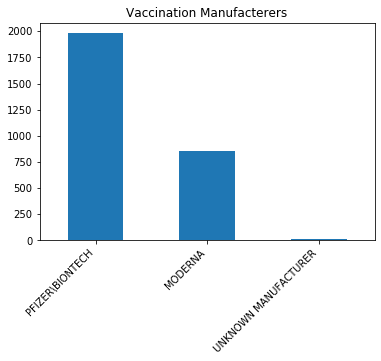

In [34]:
ax = covid_vax["VAX_MANU"].value_counts().plot(kind='bar')
t = ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
ax.set_title("Vaccination Manufacterers")
plt.show()

### Overview Data from States

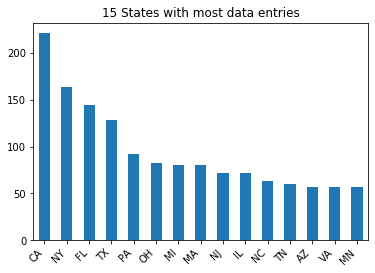

In [35]:
ax = covid_patients["STATE"].value_counts()[:15].plot(kind='bar')
t = ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
ax.set_title("15 States with most data entries")
plt.show()

### Overview Age of the Patients

In [36]:
covid_patients["AGE_YRS"].describe()

count    2284.000000
mean       54.781594
std        19.993174
min         1.080000
25%        39.000000
50%        52.000000
75%        70.000000
max       105.000000
Name: AGE_YRS, dtype: float64

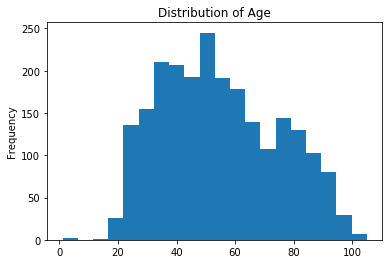

In [37]:
ax = covid_patients["AGE_YRS"].plot(kind='hist', bins=20)
ax.set_title("Distribution of Age")
plt.show()

The side effects seem to occur most often for patients roughly between 40 and 60.

### Question 1: What are the most common side effects (symptoms)?

#### Description of Symptoms Dataset
The fields described in this table provide the adverse event coded terms utilizing the
MedDRA dictionary. Coders will search for specific terms in Items 18 and 19 in
VAERS 2 form or Boxes 7 and 12 on the VAERS 1 form and code them to a
searchable and consistent MedDRA term; note that terms are included in the .csv file
in alphabetical order. There can be an unlimited amount of coded terms for a given
event. Each row in the .csv will contain up to 5 MedDRA terms per VAERS ID; thus,
there could be multiple rows per VAERS ID. For each of the VAERS_ID’s listed in the
VAERSDATA.CSV table, there is a matching record in this file, identified by
VAERS_ID.

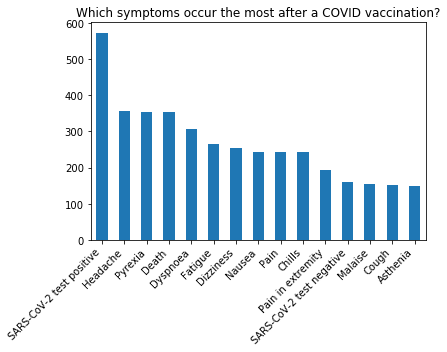

In [38]:
# Out of all symptoms, which ones occur the most?
symptom_values = covid_symptoms["SYMPTOM"].value_counts()
ax = symptom_values[:15].plot(kind='bar')
t = ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
ax.set_title("Which symptoms occur the most after a COVID vaccination?")
plt.show() 

**Observations:**
* SARS-CoV-2 test positive is the most frequent symptom
* death is a symptom with a high frequency
* otherwise: mostly lighter symptoms

### Question 2: When do these symptoms occur on average? 

In [39]:
covid_patients["NUMDAYS"].describe()

count     2390.000000
mean        30.979498
std        853.156696
min          0.000000
25%          0.000000
50%          1.000000
75%          5.000000
max      36896.000000
Name: NUMDAYS, dtype: float64

In [40]:
# Observation: some of the VAX_DATE entries are not correct, probably incorrect year
# Exclude for this visualization but data entries could still be ok for other questions
covid_patients[covid_patients["NUMDAYS"] > 40][["ONSET_DATE", "VAX_DATE", "RECVDATE"]]

,ONSET_DATE,VAX_DATE,RECVDATE
203,01/04/2021,01/02/2020,01/04/2021
296,12/30/2020,01/04/2020,01/04/2021
501,01/04/2021,01/04/2020,01/06/2021
978,01/05/2021,01/04/2020,01/09/2021
1361,12/01/2020,10/02/2020,01/13/2021
2051,01/01/2021,10/02/1982,01/20/2021
2387,01/16/2021,11/30/1983,01/22/2021
2725,01/23/2021,01/18/1920,01/26/2021
2775,01/22/2021,01/22/2020,01/26/2021


In [41]:
clean_part = covid_patients[covid_patients["NUMDAYS"] < 40]
clean_part["NUMDAYS"].describe()

count    2380.000000
mean        3.228571
std         5.042637
min         0.000000
25%         0.000000
50%         1.000000
75%         4.000000
max        39.000000
Name: NUMDAYS, dtype: float64

**Observation:** On average, the symptoms occur after ca. 3 days.

### Question 3: When tested positive for Covid, what are the most common symptoms?

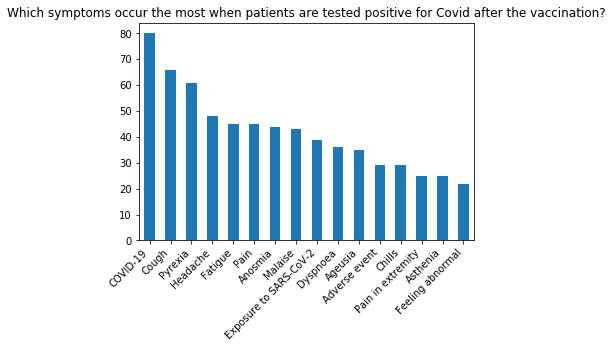

In [49]:
pos = "SARS-CoV-2 test positive"
cov_pos_id = patient_symp[patient_symp["SYMPTOM"] == pos]["VAERS_ID"]
cov_pos = patient_symp[patient_symp["VAERS_ID"].isin(cov_pos_id)]
symptom_values = cov_pos["SYMPTOM"].value_counts()
symptom_values.drop(labels=pos, inplace=True)
ax = symptom_values[:16].plot(kind='bar')
t = ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
ax.set_title("Which symptoms occur the most when patients are tested positive for Covid after the vaccination?")
plt.show() 

36 of the patients who had a positive Covid test died.


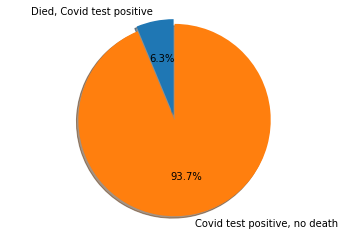

In [65]:
cov_died = cov_pos[cov_pos["DIED"] == 1]

cov_died_nr = cov_died["VAERS_ID"].nunique()
all_cov = cov_pos["VAERS_ID"].nunique()
print(cov_died_nr, "of the patients who had a positive Covid test died.")

labels = 'Died, Covid test positive', 'Covid test positive, no death'
sizes = [cov_died_nr, (all_cov-cov_died_nr)]
explode = (0.05, 0)

plot_pie(labels, sizes, explode)

Important: When a patient is tested positive for Covid after the vaccination, it is hard to tell whether the other symptoms are caused by the vaccination or the Covid infection.

### Question 3: How many patients were hospitalized or died? 

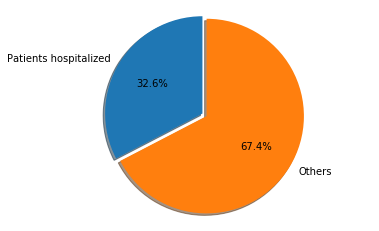

920  patients were hospitalized.


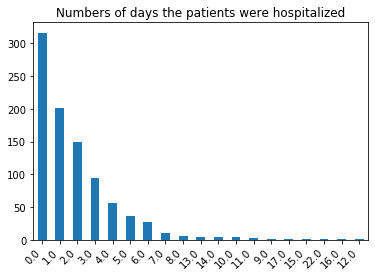

In [42]:
# Severeness of symptoms: How many patients were hospitalized?
hospitalized = covid_patients[covid_patients["HOSPITAL"] == 1]
count_hospitalized = hospitalized["VAERS_ID"].nunique()

labels = 'Patients hospitalized', 'Others'
sizes = [count_hospitalized, (covid_patients.shape[0]-count_hospitalized)]
explode = (0.05, 0)
plot_pie(labels, sizes, explode)

print(count_hospitalized, " patients were hospitalized.")
ax = hospitalized["HOSPDAYS"].value_counts().plot(kind="bar")
t = ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
ax.set_title("Numbers of days the patients were hospitalized")
plt.show()

Since a major proportion of the hospitalized patients stayed for 0 days, we can additionally look at ratio for hospitalized patients who stayed minimum 1 day.

604 stayed in a hospital for >= 1 day.


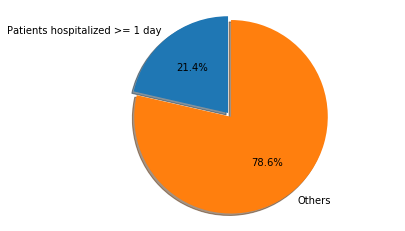

In [61]:
longer_hospitalized = hospitalized[hospitalized["HOSPDAYS"] > 0]
count_lhospitalized = longer_hospitalized["VAERS_ID"].nunique()
print(count_lhospitalized, "stayed in a hospital for >= 1 day.")

labels = 'Patients hospitalized >= 1 day', 'Others'
sizes = [count_lhospitalized, (covid_patients.shape[0]-count_lhospitalized)]
explode = (0.05, 0)
plot_pie(labels, sizes, explode)

437 patients died after vaccination.


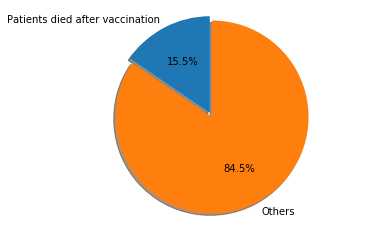

In [62]:
# What is the risk of death?
died = covid_patients[covid_patients["DIED"] == 1]
persons_died = died.shape[0]
print(persons_died, "patients died after vaccination.")
death_ratio = persons_died / covid_patients.shape[0]

labels = 'Patients died after vaccination', 'Others'
sizes = [persons_died, (covid_patients.shape[0]-persons_died)]
explode = (0.05, 0)

plot_pie(labels, sizes, explode)

### Qestion 3 a): Of the patients who died, did they have a medical history / were they ill?

305
203
318
Of all patients who died,  72.77% (318 patients) had a history of illness or were ill at the time of vaccination.


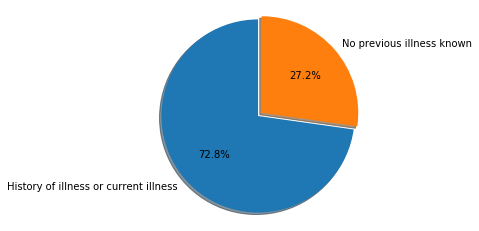

In [63]:
# Of the patients that died, how many had a history of illness?
illness = died[died["HISTORY"].notnull()]["VAERS_ID"]
illness = illness.append(died[died["CUR_ILL"].notnull()]["VAERS_ID"])
illness_nr = illness.nunique()

ratio_illness_death = illness_nr / died.shape[0] * 100
print("Of all patients who died, ", 
      "{:.2f}% ({} patients) had a history of illness or were ill at the time of vaccination.".format(ratio_illness_death, illness_nr)) 


labels = 'History of illness or current illness', 'No previous illness known'
sizes = [illness_nr, (died.shape[0]-illness_nr)]
explode = (0.05, 0)

plot_pie(labels, sizes, explode)

165 of the patients who died after vaccination had known allergies.


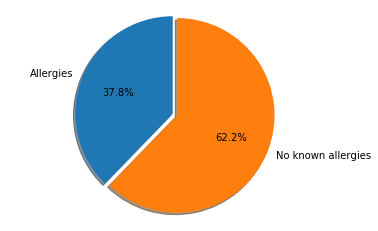

In [64]:
# Do certain allgergies lead to side effects or death?

allergies = died[died["ALLERGIES"].notnull()]["VAERS_ID"]
ratio_allergies_death = allergies.nunique() / died.shape[0] * 100

allergies_nr = allergies.nunique()
print(allergies_nr, "of the patients who died after vaccination had known allergies.")


labels = 'Allergies', 'No known allergies'
sizes = [allergies_nr, (died.shape[0]-allergies_nr)]
explode = (0.05, 0)

plot_pie(labels, sizes, explode)

### Question 3 b): How old were the patients who died after the vaccination?

In [47]:
died["AGE_YRS"].describe()

count    411.000000
mean      76.421119
std       14.712540
min        1.080000
25%       66.500000
50%       79.000000
75%       88.000000
max      105.000000
Name: AGE_YRS, dtype: float64

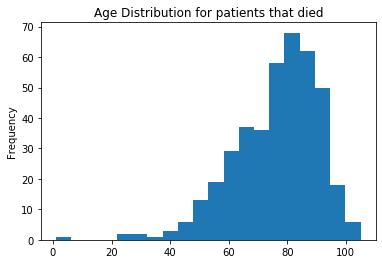

In [48]:
ax = died["AGE_YRS"].plot(kind='hist', bins=20)
ax.set_title("Age Distribution for patients that died")
plt.show()

**Observation:** 
Higher mean age than our mean age in the complete dataset (which is at 54). 

### Question 5: Can we predict the hospitalization of a patient based on the data?

#### Dataset Cleaning for Prediction Task

In [51]:
# Preparation for Data Cleaning
# exclude symptoms with occurence < 20
symp_counts = pt_symp_vax["SYMPTOM"].value_counts()
pt_symp_vax = pt_symp_vax.loc[pt_symp_vax["SYMPTOM"].isin(symp_counts.index[symp_counts >= 20])]

In [52]:
# clean NUMDAYS: take only the ones with day difference < 40
pt_symp_vax = pt_symp_vax[pt_symp_vax["NUMDAYS"] < 40]

In [53]:
x_cols = ["VAERS_ID", "AGE_YRS", "SEX", "SYMPTOM", "ER_ED_VISIT", "NUMDAYS", "VAX_MANU"]
y_col = "HOSPITAL"
data, y = clean_data(pt_symp_vax, x_cols, y_col)

Shapes match


#### Data Modeling

In [57]:
def train_test_classifier(X, y, model, model_name):
    ''' Split dataset into train and test, 
    train the model, predict and print the accuracy score
    
    INPUT: 
    X - pandas dataframe dataset to predict from
    y - pandas series labels
    model - classification model (initialized)
    model_name - name of model as string
    '''
    # Split data into train and test dataset
    X_train, X_test, y_train, y_test = train_test_split(data, y, test_size = .35, random_state=42)
    
    # Fit model
    model.fit(X_train, y_train)
    length_y_test = len(y_test) #num in y_test
    length_y_train = len(y_train) #num in y_train
    
    # Calculate score
    train_score = model.score(X_train, y_train)
    test_score = model.score(X_test, y_test)
    
    print("Training Accuracy Score for the model {} was {} on {} values.".format(model_name, train_score, length_y_train))
    print("Test Accuracy Score for the model {} was {} on {} values.".format(model_name, test_score, length_y_test))

In [58]:
lr_model = LogisticRegression(random_state=0, solver='lbfgs')
train_test_classifier(data, y, lr_model, "Logistic Regression")

Training Accuracy Score for the model Logistic Regression was 0.5508637236084453 on 6252 values.
Test Accuracy Score for the model Logistic Regression was 0.5527175527175527 on 3367 values.


In [59]:
rf_model = RandomForestClassifier(max_depth=2, random_state=0)
train_test_classifier(data, y, rf_model, "Random Forest Classifier")

Training Accuracy Score for the model Random Forest Classifier was 0.6641074856046065 on 6252 values.
Test Accuracy Score for the model Random Forest Classifier was 0.6554796554796555 on 3367 values.


c:\users\z0007021\appdata\local\continuum\anaconda3\envs\anodet\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [60]:
gb_model = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, 
                                      max_depth=1, random_state=0)
train_test_classifier(data, y, gb_model, "Gradient Boosting Classifier")

Training Accuracy Score for the model Gradient Boosting Classifier was 0.763275751759437 on 6252 values.
Test Accuracy Score for the model Gradient Boosting Classifier was 0.7463617463617463 on 3367 values.


**Results:** 
* no optimal prediction results
* could improve through hyperparameter optimization, additional information (e.g. allergies), use more data

### Results - Summary

**Question 1: What are the most common side effects (symptoms)?**
* SARS-CoV-2 test positive is the most frequent symptom
* death is a symptom with a high frequency
* otherwise: mostly lighter symptoms

**Question 2: When do these symptoms occur on average?**
* on average, the symptoms occur after ca. 3 days

**Question 3: When tested positve for Covid, what are the most common symptoms?**
* getting COVID19
* otherwise: mostly lighter symptoms like coughing, headache
* Important: When a patient is tested positive for Covid after the vaccination, it is hard to tell whether the other symptoms are caused by the vaccination or the Covid infection.
* of the patients with positive Covid test, 36 (6.3 %) died (which is lower than the general rate of death in this dataset)

**Question 4: Severe symptoms - How many patients were hospitalized or died?**
* 920 patients (32.6 %) were hospitalized, but: also stay for 0 days as entry
* 604 patients (21.4 %) stayed in a hospital for >= 1 day
* 437 patients (15.5 %) died after vaccination

**Question 5: What is the (medical) background of the patients who died?**
* Of all patients who died, 318 patients (72.8 %) had a history of illness or were ill at the time of vaccination
* 165 of the patients (37.8 %) who died after vaccination had known allergies
* The mean age of the patients who died (76) is higher than the mean age in the complete dataset (which is at 54). 

**Question 6: Can we predict the hospitalization of a patient based on the data?**
* after trying out a few models with the chosen features, the best model (Gradient Boosting Classifier) reaches an accuracy of 74.6 % $\rightarrow$ not optimal, could be improved by hyperparameter optimization and adding additional information, more data (gives some sort of direction with an uncertainty)
* maybe the transformation of the symptoms was not the best idea, a combination might give some indication

